<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Dataset-handling" data-toc-modified-id="Dataset-handling-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Dataset handling</a></span></li><li><span><a href="#Simple-psychometric-fits" data-toc-modified-id="Simple-psychometric-fits-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Simple psychometric fits</a></span><ul class="toc-item"><li><span><a href="#Percent-Correct" data-toc-modified-id="Percent-Correct-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>Percent Correct</a></span></li><li><span><a href="#Proportion-Choose-Right" data-toc-modified-id="Proportion-Choose-Right-2.2"><span class="toc-item-num">2.2&nbsp;&nbsp;</span>Proportion Choose Right</a></span></li></ul></li><li><span><a href="#Simplest-effects-of-CP-on-percent-correct" data-toc-modified-id="Simplest-effects-of-CP-on-percent-correct-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Simplest effects of CP on percent correct</a></span></li><li><span><a href="#Logistic-regression" data-toc-modified-id="Logistic-regression-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Logistic regression</a></span><ul class="toc-item"><li><span><a href="#Single-predictor" data-toc-modified-id="Single-predictor-4.1"><span class="toc-item-num">4.1&nbsp;&nbsp;</span>Single predictor</a></span><ul class="toc-item"><li><span><a href="#Signed-coherence" data-toc-modified-id="Signed-coherence-4.1.1"><span class="toc-item-num">4.1.1&nbsp;&nbsp;</span>Signed coherence</a></span></li></ul></li><li><span><a href="#More-predictors" data-toc-modified-id="More-predictors-4.2"><span class="toc-item-num">4.2&nbsp;&nbsp;</span>More predictors</a></span><ul class="toc-item"><li><span><a href="#Single-subject" data-toc-modified-id="Single-subject-4.2.1"><span class="toc-item-num">4.2.1&nbsp;&nbsp;</span>Single subject</a></span></li></ul></li></ul></li></ul></div>

<!--
IRdisplay::display_html(file='../code_hiding.html')
if the line above generates an error, it could be due to this:
https://github.com/IRkernel/IRdisplay/issues/41
In the meantime, the code below is enough; it works on nbviewer but not on the notebook directly
-->

<script>
  code_show=true;
  function code_toggle() {
    if (code_show){
      $('div.input').hide();
    } else {
      $('div.input').show();
    }
    code_show = !code_show
  } 
  $( document ).ready(code_toggle);
</script>
<font size=4>
<a href="javascript:code_toggle()">Toggle ON/OFF</a>
code cells.
</font>

# Fitting psychometric functions

This notebook analyzes data from `Pilot 13-14` datasets.

In [1]:
library(data.table)
library(ggplot2)        
source('../../R/R_functions.r')

In [2]:
# define constants for notebook

# todo: the following is VERY INELEGANT!
psubj13 <- c(37,2.5,0.5,0.001)
names(psubj13) <- c('threshold','slope','guess','lapse')
psubj14 <- c(23,2.5,0.5,0.001)
names(psubj14) <- c('threshold','slope','guess','lapse')
QuestParams <- list(psubj13, psubj14)
names(QuestParams) <- c('13', '14')

# recall, to access threshold of subject 13, type
# th13 <- QuestParams[['13']]['threshold']

# plot-specific constants
PLOT_TITLE_FONT_SIZE <- 18
PLOT_SUBTITLE_FONT_SIZE <- 13 
AXES_LABEL_FONT <- 14
AXES_FONT <- 13

ERROR_WIDTH <- 4
SMALL_ERROR_WIDTH <- .01*ERROR_WIDTH

LINE_WIDTH <- 1.4
POINT_SIZE <- 2
SMALL_DOT_SIZE <- 1

In [3]:
mytheme <- theme(
    plot.title=element_text(size=PLOT_TITLE_FONT_SIZE, lineheight=1.2),  # title
    plot.subtitle=element_text(size=PLOT_SUBTITLE_FONT_SIZE),            # subtitle
    plot.caption=element_text(size=PLOT_SUBTITLE_FONT_SIZE),             # caption
    axis.title.x=element_text(size=AXES_LABEL_FONT),                     # X axis title
    axis.title.y=element_text(size=AXES_LABEL_FONT),                     # Y axis title
    axis.text.x=element_text(size=AXES_FONT),                            # X axis text
    axis.text.y=element_text(size=AXES_FONT)                             # Y axis text
    )

## Dataset handling

Let's load and inspect the dataset.

In [4]:
# load dataset
data <- fread('../../data/Pilot13-14/psychophysical_data.csv')

# set some variables as factors
data[,`:=`(
    presenceCP=as.factor(presenceCP),
    choice=as.factor(choice),
    facVD=as.factor(viewingDuration)
    )
]

In [5]:
# define a 'signedCohLast' column that assigns a sign to the coherence based on the direction in the last epoch
data[,signedCohLast := coherence]
data[signedCoherence < 0, signedCohLast := signedCoherence]
data[choice=="left" & presenceCP=="yes" & correct, signedCohLast:= - coherence]
data[choice=="right" & presenceCP=="yes" & !correct, signedCohLast:= - coherence]

In [6]:
str(data)

Classes ‘data.table’ and 'data.frame':	977 obs. of  13 variables:
 $ pilotID        : int  13 13 13 13 13 13 13 13 13 13 ...
 $ taskID         : int  1 1 1 1 1 1 1 1 1 1 ...
 $ validTrialCount: int  1 2 3 4 5 6 7 8 9 10 ...
 $ choice         : Factor w/ 2 levels "left","right": 2 1 1 2 2 1 2 1 2 2 ...
 $ correct        : logi  TRUE FALSE TRUE TRUE TRUE TRUE ...
 $ presenceCP     : Factor w/ 2 levels "no","yes": 1 1 1 1 1 1 1 1 1 1 ...
 $ viewingDuration: num  0.2 0.2 0.2 0.2 0.2 0.2 0.2 0.2 0.2 0.2 ...
 $ signedCoherence: num  50 50 -57 57 56 -56 56 -55 55 55 ...
 $ coherence      : num  50 50 57 57 56 56 56 55 55 55 ...
 $ choice_time    : num  0.363 0.833 0.578 0.572 0.633 ...
 $ exactVD        : num  0.22 0.203 0.203 0.219 0.219 ...
 $ facVD          : Factor w/ 3 levels "0.2","0.3","0.4": 1 1 1 1 1 1 1 1 1 1 ...
 $ signedCohLast  : num  50 50 -57 57 56 -56 56 -55 55 55 ...
 - attr(*, ".internal.selfref")=<externalptr> 


In [7]:
print('first 6 rows of data.table')
head(data)

[1] "first 6 rows of data.table"


pilotID,taskID,validTrialCount,choice,correct,presenceCP,viewingDuration,signedCoherence,coherence,choice_time,exactVD,facVD,signedCohLast
13,1,1,right,TRUE,no,0.2,50,50,0.3633654,0.2203390,0.2,50
13,1,2,left,FALSE,no,0.2,50,50,0.8330632,0.2033898,0.2,50
13,1,3,left,TRUE,no,0.2,-57,57,0.5782815,0.2033898,0.2,-57
13,1,4,right,TRUE,no,0.2,57,57,0.5724611,0.2193786,0.2,57
13,1,5,right,TRUE,no,0.2,56,56,0.6325272,0.2188400,0.2,56
13,1,6,left,TRUE,no,0.2,-56,56,0.6130831,0.2033898,0.2,-56


## Simple psychometric fits 

### Percent Correct

Is the percent correct as a function of coherence value in the task node similar to the one estimated in the Quest node?

In [8]:
# steps
# 1. For each subject, get parameters of psychometric curve estimated by Quest
# 2. plot the curve
# 3. overlay data from task node, for appropriate viewing duration
# 4. overlay theoretical curve corresponding to the fitted logistic regression
# 5. plot everything

# The final plot should use a single data.table
# data[taskID==2]
# progress
# 1. complete
# 2. complete
# 3. complete

In [9]:
subj <- '13'
x <- seq(100)
psychometric <- psi_corr(weibull, QuestParams[[subj]])
y <- psychometric(x)

questCurve <- data.table(x=x, y=y)

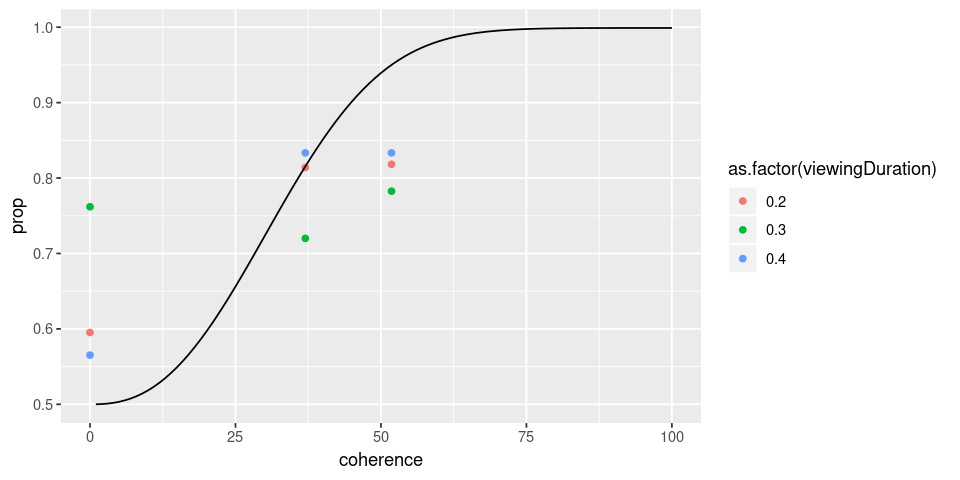

In [10]:
# control output figure size
options(repr.plot.width=8, repr.plot.height=4)

ggplot(data[pilotID==subj & taskID==2 & presenceCP=='no',
            .(prop=sum(correct==TRUE)/.N),by=.(coherence, viewingDuration)], aes(x=coherence, y=prop)) +
        geom_point(aes(col=as.factor(viewingDuration))) + 
        geom_line(aes(x=x, y=y), data=questCurve)

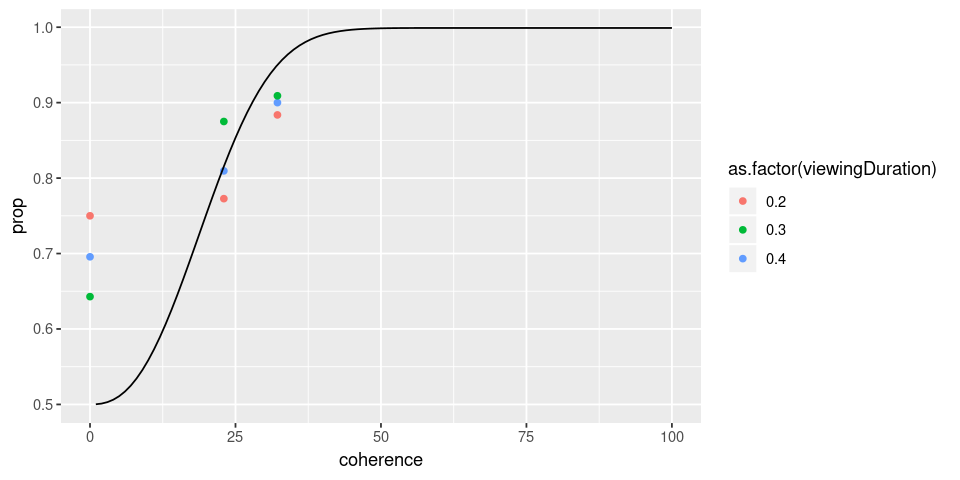

In [11]:
subj <- '14'
x <- seq(100)
psychometric <- psi_corr(weibull, QuestParams[[subj]])
y <- psychometric(x)

questCurve <- data.table(x=x, y=y)
ggplot(data[pilotID==subj & taskID==2 & presenceCP=='no',
            .(prop=sum(correct==TRUE)/.N),by=.(coherence, viewingDuration)], aes(x=coherence, y=prop)) +
        geom_point(aes(col=as.factor(viewingDuration))) + 
        geom_line(aes(x=x, y=y), data=questCurve)

### Proportion Choose Right

Let's fit simple logistic models, grouping by *subject and viewing duration*. 

In [12]:
# for an explanation of masked objects, see here:
# https://stackoverflow.com/a/39137111
# library(quickpsy)
print("I skip this section to avoid using the 'quickpsy' package for now")

[1] "I skip this section to avoid using the 'quickpsy' package for now"


In [13]:
# data[,numChoice:=0]
# data[choice=='right',numChoice:=1]

In [14]:
# fit <- quickpsy(data[taskID==2], signedCohLast, numChoice, grouping=.(pilotID, facVD))

In [15]:
# names(fit)

In [16]:
# from http://dlinares.org/basicsquickpsy.html
# ggplot() +
#  facet_wrap(~pilotID) +
#  geom_line(data = fit$curvesbootstrap, aes(x = x, y = y, color = facVD, 
#                    group=paste(sample,facVD)), lwd = .2, alpha = .4) +   
#  geom_line(data = fit$curves, aes(x = x, y = y, group = facVD), 
#            color = 'black') +
#  geom_point(data = fit$averages, aes(x = signedCohLast, y = prob, color = facVD), size = 4)

## Simplest effects of CP on percent correct

**Question:** Does the physical presence of a CP affect state inference?  
**Hypotheses:** At fixed viewing duration the (physical) presence of a CP will decrease accuracy.  
**Method:** Hypothesis testing, i.e. is the difference in percent correct between the `CP` and `nonCP` conditions significantly different from 0?

Let's build a contingency table and perform [Fisher's exact test](https://en.wikipedia.org/wiki/Fisher%27s_exact_test#Example).

In [17]:
subj <- '13'
task <- '2'
vd <- .4
maxCoh <- as.numeric(data[pilotID==subj & taskID==task, max(coherence)])
cat('max coh for subject', subj, 'on task', task, 'is', maxCoh, '\n')
contingency <- as.matrix(data[viewingDuration==vd & pilotID==subj & taskID==task & coherence>0 & coherence < maxCoh, 
                              .(Corrrect=sum(correct),Incorrect=sum(!correct)), by=presenceCP], rownames=TRUE)
t(contingency)
fisher.test(t(contingency)) # two-sided test; see ?fisher.test for help

max coh for subject 13 on task 2 is 51.81503 


,yes,no
Corrrect,24,15
Incorrect,2,3



	Fisher's Exact Test for Count Data

data:  t(contingency)
p-value = 0.3859
alternative hypothesis: true odds ratio is not equal to 1
95 percent confidence interval:
  0.2398253 31.2533056
sample estimates:
odds ratio 
  2.351029 


In [18]:
subj <- '14'
maxCoh <- as.numeric(data[pilotID==subj & taskID==task, max(coherence)])
cat('max coh for subject', subj, 'on task', task, 'is', maxCoh, '\n')
contingency <- as.matrix(data[viewingDuration==vd & pilotID==subj & taskID==task & coherence>0 & coherence < maxCoh, 
                              .(Corrrect=sum(correct),Incorrect=sum(!correct)), by=presenceCP], rownames=TRUE)
t(contingency)
fisher.test(t(contingency)) # two-sided test; see ?fisher.test for help

max coh for subject 14 on task 2 is 32.20934 


,yes,no
Corrrect,17,17
Incorrect,6,4



	Fisher's Exact Test for Count Data

data:  t(contingency)
p-value = 0.724
alternative hypothesis: true odds ratio is not equal to 1
95 percent confidence interval:
 0.1172459 3.4452526
sample estimates:
odds ratio 
 0.6728156 


We conclude that the test is not significant, i.e., we do **not** reject the null hypothesis that percent correct is the same with and without change points.

## Logistic regression

### Single predictor

#### Signed coherence
<a id="cohpred"></a>

We start by fitting our simplest logistic regression model, called **M1**
$$\log\frac{p_i}{1-p_i}=\beta_0+\beta_1x^\text{sc}_i$$
where $p_i$ is the proportion of right choices at stimulus level $i$ and $x^\text{sc}$ is the signed coherence value.

And for now, let's only study one subject.

In [19]:
subj <- '13'
task <- '2'

In [20]:
# simplify existing dataset in order to consider 1 subject and 1 task:
single <- data[taskID==task & pilotID==subj]
# head(single)

In [21]:
# fit_logistic_single_pred(data[pilotID==subj & taskID==task], choice, "right", signedCohLast)
M1 <- glm(choice ~ signedCohLast, single, family=binomial())
M1


Call:  glm(formula = choice ~ signedCohLast, family = binomial(), data = single)

Coefficients:
  (Intercept)  signedCohLast  
     -0.26200        0.03322  

Degrees of Freedom: 391 Total (i.e. Null);  390 Residual
Null Deviance:	    539.3 
Residual Deviance: 428.7 	AIC: 432.7

In [22]:
coherences <- seq(-100,100,10)
predictions <- my_logistic(coherences, linear_func(coef(summary(M1))))

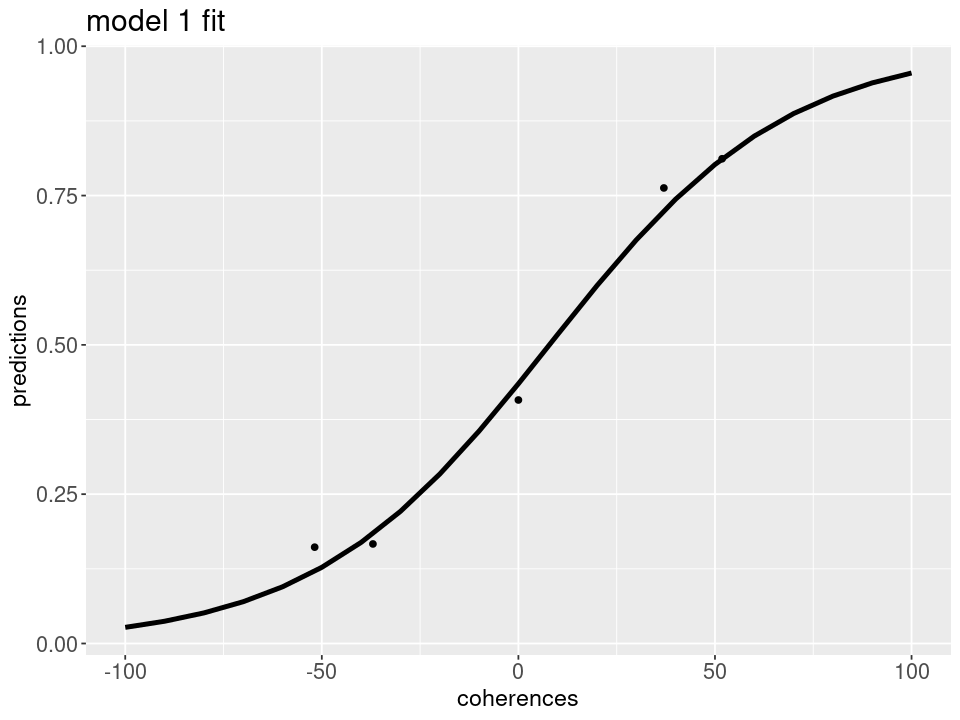

In [23]:
# control output figure size
options(repr.plot.width=8, repr.plot.height=6)
ggplot(data.table(coherences, predictions), aes(x=coherences, y=predictions)) +
    geom_line(size = 1.4) + 
    geom_point(aes(x=signedCohLast, y=propRight), 
               inherit.aes=FALSE, 
               data=single[,.(propRight=sum(choice=='right')/.N),by=.(signedCohLast)]) +
    labs(title='model 1 fit') + 
    mytheme    

In [24]:
# subj <- '14'
# unique(data[pilotID==subj & taskID==task & order(signedCohLast),.(signedCohLast)][,signedCohLast])

In [25]:
# fit_logistic_single_pred(data[pilotID==subj & taskID==task], choice, "right", signedCohLast)

### More predictors
#### Single subject

Let's first try to fit what we call **Model 2**, or **M2**.
$$ \text{logit}(p_\text{right}) =
    \sum_{i\in\text{VDs}}\mathbb{1}_{\text{VD}_i}\left(
    \beta^{VD}_i +
    \beta^{VD\textsf{x}coh}_iX_{coh}\right)$$

In [26]:
M2 <- glm(choice ~ facVD + signedCohLast:facVD - 1, data=single, family=binomial())

In [27]:
M2


Call:  glm(formula = choice ~ facVD + signedCohLast:facVD - 1, family = binomial(), 
    data = single)

Coefficients:
              facVD0.2                facVD0.3                facVD0.4  
              -0.24522                -0.13911                -0.45002  
facVD0.2:signedCohLast  facVD0.3:signedCohLast  facVD0.4:signedCohLast  
               0.03352                 0.02481                 0.04411  

Degrees of Freedom: 392 Total (i.e. Null);  386 Residual
Null Deviance:	    543.4 
Residual Deviance: 423.5 	AIC: 435.5

We will overlay the fitted psychometric curves for each viewing duration:

In [28]:
# we gather all the predictions in a single data.table
factor_levels <- levels(single[,facVD])
num_factors = length(factor_levels)
coherence <- rep(coherences, times=num_factors)  # coherences defined in some cell above
VD <- c()
predictions <- c()

In [29]:
for (vd in factor_levels) {
    VD <- c(VD, rep(c(vd), times = length(coherences)))
    coef_names <- c(paste("facVD",vd, sep=''), paste("facVD",vd,":signedCohLast", sep=''))
    fitted_betas <- coef(summary(M2))[coef_names, "Estimate"]
    eta <- linear_func(fitted_betas)
    predictions <- c(predictions, my_logistic(coherences, eta))
}

In [30]:
prediction_data <- data.table(coherence, VD, predictions)
prediction_data[,VD:=as.factor(VD)]

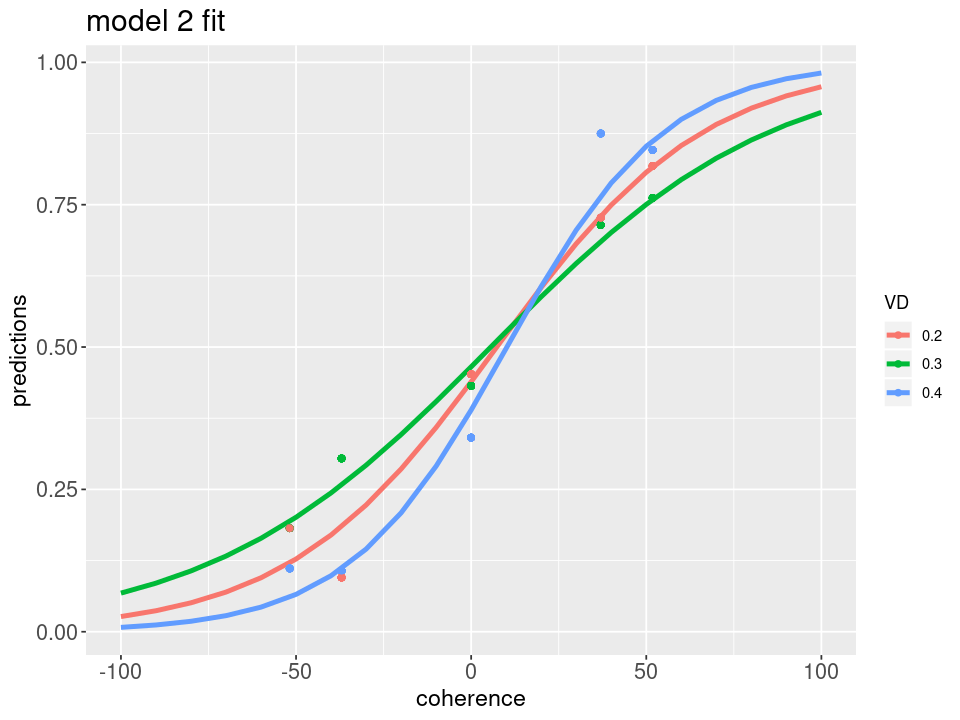

In [31]:
# control output figure size
options(repr.plot.width=8, repr.plot.height=6)
ggplot(prediction_data, aes(x=coherence, y=predictions)) +
    geom_line(aes(col=VD), size = 1.4) + 
    geom_point(aes(col=facVD, x=signedCohLast, y=propRight), 
               inherit.aes=FALSE, 
               data=single[,propRight:=sum(choice=='right')/.N,by=.(signedCohLast, facVD)]) +
    labs(title='model 2 fit') +
    mytheme    

Can we already select between M1 and M2?

We now tackle **Model 3**, or **M3**.
$$ \text{logit}(p_\text{right}) =
    \sum_{j\in\text{CPs}}\mathbb{1}_{\text{CP}_j}\left(
    \beta^{CP}_j + 
    \beta^{CP\textsf{x}coh}_jX_{coh} \right)$$

In [32]:
M3 <- glm(choice ~ presenceCP + signedCohLast:presenceCP - 1, data=single, family=binomial())
M3


Call:  glm(formula = choice ~ presenceCP + signedCohLast:presenceCP - 
    1, family = binomial(), data = single)

Coefficients:
               presenceCPno                presenceCPyes  
                   -0.20058                     -0.39786  
 presenceCPno:signedCohLast  presenceCPyes:signedCohLast  
                    0.03134                      0.03769  

Degrees of Freedom: 392 Total (i.e. Null);  388 Residual
Null Deviance:	    543.4 
Residual Deviance: 427.6 	AIC: 435.6

In [33]:
# we gather all the predictions in a single data.table, just as for model 2
factor_levels <- levels(single[,presenceCP])
num_factors = length(factor_levels)
coherence <- rep(coherences, times=num_factors)  # coherences defined in some cell above
CP <- c()
predictions <- c()
for (cp in factor_levels) {
    CP <- c(CP, rep(c(cp), times = length(coherences)))
    coef_names <- c(paste("presenceCP",cp, sep=''), paste("presenceCP",cp,":signedCohLast", sep=''))
    fitted_betas <- coef(summary(M3))[coef_names, "Estimate"]
    eta <- linear_func(fitted_betas)
    predictions <- c(predictions, my_logistic(coherences, eta))
}
prediction_data <- data.table(coherence, CP, predictions)
prediction_data[,CP:=as.factor(CP)]

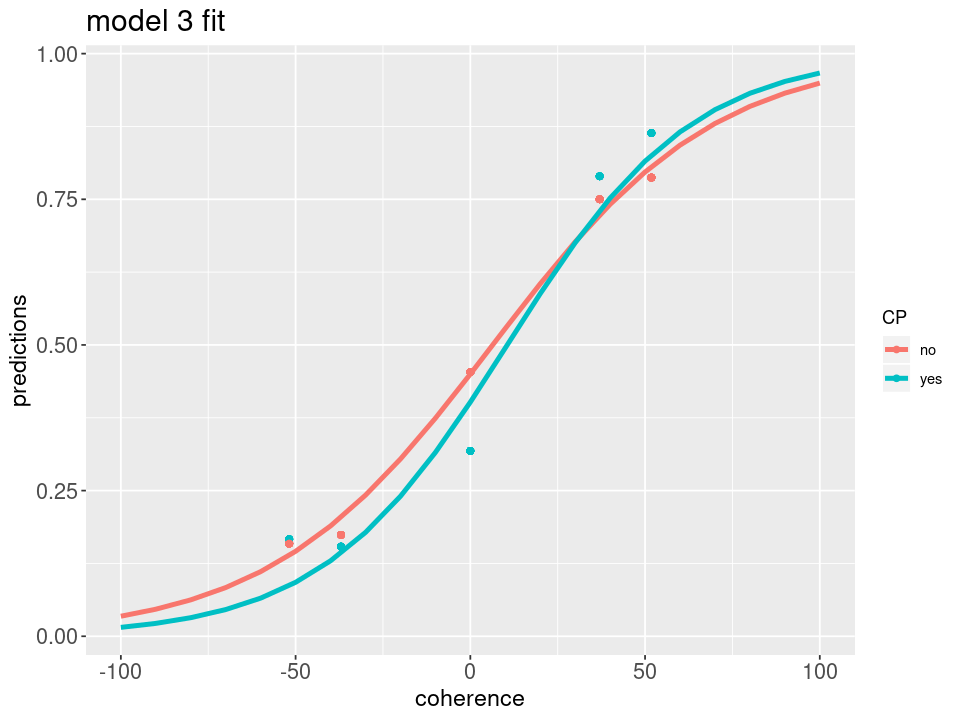

In [34]:
# control output figure size
options(repr.plot.width=8, repr.plot.height=6)
ggplot(prediction_data, aes(x=coherence, y=predictions)) +
    geom_line(aes(col=CP), size = 1.4) + 
    geom_point(aes(col=presenceCP, x=signedCohLast, y=propRight), 
               inherit.aes=FALSE, 
               data=single[,propRight:=sum(choice=='right')/.N,by=.(signedCohLast, presenceCP)]) +
    labs(title='model 3 fit') +
    mytheme   

Finally, let's fit **Model 4**, i.e. **M4**:
$$ \text{logit}(p_\text{right}) =
    \sum_{(i,j)\in\text{VDs}\times\text{CPs}}
    \mathbb{1}_{\text{VD}_i}\beta^{VD}_i+
    \mathbb{1}_{\text{CP}_j}\beta^{CP}_j +
    \left(
    \beta^{VD\textsf{x}coh}_i\mathbb{1}_{\text{VD}_i}+
    \beta^{CP\textsf{x}coh}_j\mathbb{1}_{\text{CP}_j}
    \right)
    X_{coh}$$

In [35]:
M4 <- glm(choice ~ facVD + signedCohLast:facVD + presenceCP + signedCohLast:presenceCP - 1, data=single, family=binomial())
M4


Call:  glm(formula = choice ~ facVD + signedCohLast:facVD + presenceCP + 
    signedCohLast:presenceCP - 1, family = binomial(), data = single)

Coefficients:
                   facVD0.2                     facVD0.3  
                  -0.245216                    -0.037449  
                   facVD0.4                presenceCPyes  
                  -0.342660                    -0.227348  
     facVD0.2:signedCohLast       facVD0.3:signedCohLast  
                   0.033522                     0.021793  
     facVD0.4:signedCohLast  signedCohLast:presenceCPyes  
                   0.040710                     0.007243  

Degrees of Freedom: 392 Total (i.e. Null);  384 Residual
Null Deviance:	    543.4 
Residual Deviance: 422.3 	AIC: 438.3

In model 4 above, I am not sure why the fit doesn't provide me for a pair of coefficients for the 'no' CP case...

In [36]:
anova(M1, M2, M3, M4)

Resid. Df,Resid. Dev,Df,Deviance
390,428.7119,NA,NA
386,423.4579,4,5.253972
388,427.6173,-2,-4.159365
384,422.3213,4,5.295949
